In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from pyrates import OperatorTemplate, NodeTemplate, CircuitTemplate, clear

%matplotlib inline

In [3]:
# define QIF operator with conductance-based synapses
eqs = [
    "r' = (Delta/(pi*tau) + 2.0*r*v) / tau",
    "v' = (v^2 + eta + I_ext - (pi*tau*r)^2)/tau + I_e - I_i",
    "I_e' = r_e - I_e/tau_e",
    "I_i' = r_i - I_i/tau_i"
]
variables = {
    "r": "output(0.0)",
    "v": "variable(0.0)",
    "I_e": "variable(0.0)",
    "I_i": "variable(0.0)",
    "Delta": 1.0,
    "tau": 1.0,
    "eta": -3.0,
    "v_e": 4.0,
    "v_i": -4.0,
    "tau_e": 0.5,
    "tau_i": 2.0,
    "I_ext": "input(0.0)",
    "r_e": "input(0.0)",
    "r_i": "input(0.0)"
}
op = OperatorTemplate(name="qif", equations=eqs, variables=variables, path=None)

# define QIF node
node = NodeTemplate(name="qif_node", operators=[op], path=None)

In [4]:
# define STN-GPe network
edges = [
    ("stn/qif/r", "gpe/qif/r_e", None, {"weight": 10.0, "delay": 2.4, "spread": 0.8}),
    ("gpe/qif/r", "stn/qif/r_i", None, {"weight": 2.0, "delay": 1.5, "spread": 0.5}),
    ("gpe/qif/r", "gpe/qif/r_i", None, {"weight": 1.0, "delay": 4.0, "spread": 1.0})
]
stn_gpe = CircuitTemplate(name="qif", nodes={"stn": node, "gpe": node}, edges=edges, path=None)

# adjust parameters
stn_gpe.update_var(node_vars={
    "stn/qif/tau": 13.0,
    "gpe/qif/tau": 16.0,
    "stn/qif/eta": 1.0,
    "gpe/qif/eta": -7.0,
    "stn/qif/Delta": 1.0,
    "gpe/qif/Delta": 3.0,
    "stn/qif/tau_e": 10.0,
    "gpe/qif/tau_e": 10.0,
    "stn/qif/tau_i": 8.0,
    "gpe/qif/tau_i": 8.0,
})

<CircuitTemplate 'None'>

In [5]:
# simulation parameters
T = 1000.0
T_on = 200.0
T_off = 600.0
dt = 1e-3
dts = 1e-2

# input definition
steps = int(np.round(T/dt))
start = int(np.round(T_on/dt))
stop = int(np.round(T_off/dt))
inp = np.zeros((steps,))
inp[start:stop] = 8.0
I_ext = gaussian_filter1d(inp, 50)

# perform simulation
res = stn_gpe.run(simulation_time=T, step_size=dt, sampling_step_size=dts, solver="scipy", method="LSODA",
                  outputs={"stn": "stn/qif/r", "gpe": "gpe/qif/r"}, inputs={"stn/qif/I_ext": inp}, max_step=100)
clear(stn_gpe)

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 71.64349489999995s.


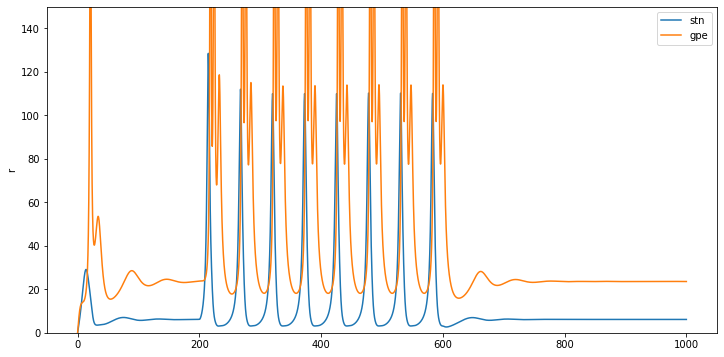

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(res*1e3)
ax.set_ylabel("r")
ax.set_ylim([0.0, 150.0])
plt.legend(res.columns.values)